In [207]:
# Libraries for data load
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine

# Library for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries for data cleaning and pre-processing
import nltk
nltk.download(['punkt', 'wordnet'])
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator,TransformerMixin

# Libraries for pipeline and model building
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Libraries for model evaluation
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score, make_scorer
import pickle

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hianj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hianj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hianj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hianj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_data(db, database_name, feature, pos):
    
    # load data from database
    engine = create_engine(db)
    
    sql = 'SELECT * FROM ' + database_name
    df = pd.read_sql(sql, engine)
    X = df[feature]
    y = df.iloc[:,pos:]
    
    return X, y

In [5]:
def tokenize(text):
    '''
    To clean and pre-process the raw data. Here are the steps done by the function
    1) Clean the data to remove all HTML tags
    2) Normalize by converting the text to lowercase and removing punctuations
    3) Split text into tokens
    4) Remove English stop words
    
    '''
    
    # Replace url tags with the string 'urlplaceholder'
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
        
    # Convert to lowercase
    text = text.lower() 
    
    # Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove stop words
    words = [w for w in words if w not in stopwords.words("english")]
    
    # Lemmatize each word to create clean tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='n').strip() for word in words]
    clean_tokens = [lemmatizer.lemmatize(token, pos='v').strip() for token in lemmatized_tokens]
    
    return clean_tokens

In [197]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    '''
    The purpose of this class is to create a feature which indicates whether or not a sentence starts with a verb.
    It returns a True if the sentence starts with a verb or it is a re-tweet and False otherwise.
    '''

    def starting_verb(self, text):
        # tokenize by sentences
        sentence_list = nltk.sent_tokenize(text)      
        
        for sentence in sentence_list:
            
            # tokenize each sentence into words and tag part of speech
            pos_tags = nltk.pos_tag(tokenize(sentence))
            
            if len(pos_tags) > 1:
                # index pos_tags to get the first word and part of speech tag
                first_word, first_tag = pos_tags[0]
            
                # return true if the first word is an appropriate verb or RT for retweet
                if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                    return 1
                else:
                    return 0
            else:
                return 0
            

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.starting_verb)
        X_tagged = pd.DataFrame(X_tagged)
        X_tagged = X_tagged.replace(np.nan, 0)
        
        return X_tagged

In [218]:
def build_pipeline_basic():
    pipeline = Pipeline([('vect',CountVectorizer(tokenizer=tokenize)),
                        ('tfidf',TfidfTransformer()),
                        ('classifier', MultiOutputClassifier(SGDClassifier())) 
                        ])
    return pipeline

In [219]:
def build_grid_search_model(pipeline):
    parameters = {'classifier__estimator__loss' : ['hinge', 'log'],
                  'classifier__estimator__alpha' : [0.00005, 0.001]
                  }
    
    model = GridSearchCV (pipeline, param_grid= parameters, cv=2, n_jobs=-1, verbose=3)
    
    return model

In [220]:
def build_pipeline_improved():
    '''
    This function creates various features using CountVectorizer, TfidfTransformer and StartingVerbExtractor.
    For model building, RandomForestClassifier is used. 
    The function returns a pipeline model using all of the above.
    '''

    pipeline = Pipeline([

        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', MultiOutputClassifier(AdaBoostClassifier()))
    ])

    return pipeline

In [165]:
def train(X_train, X_test, y_train, y_test, model):
    '''
    This function will train the model and predict on the test data.
    It returns the predicted y values
    '''   
    
    print('Model training started')
    model.fit(X_train, y_train) # Train the model on train data
    print('Model training completed')
    
    print('Prediction started')
    y_pred = model.predict(X_test) #Predict on test data
    print('Prediction complete')
    
    target_col_names = y_test.columns
    y_pred = pd.DataFrame(y_pred, columns = target_col_names) #Convert y_pred to a dataframe
    
    return y_pred

In [166]:
def model_evaluation(y_true, y_pred):
    '''
    This function will loop through each target column and calculate the accuracy, precision, recall and F1-score.
    The resulting dataframe will be returned.
    '''    
    
    eval_measures = {} # Dictionary to store the performance measures
    target_col_names = y_test.columns # Get all the column names present in the target
    
    for col in target_col_names:
        eval_measures[col] = {}
        precision, recall, f1_score, support = precision_recall_fscore_support(y_true.loc[:,col], y_pred.loc[:,col], average='macro')
        accuracy = accuracy_score(y_true.loc[:,col], y_pred.loc[:,col])
        
        eval_measures[col]['f1_score'] = f1_score
        eval_measures[col]['precision'] = precision
        eval_measures[col]['recall'] = recall        
        eval_measures[col]['accuracy'] = accuracy 
    
    df_eval_measures = pd.DataFrame(eval_measures)
    df_eval_measures = df_eval_measures.transpose()
    df_eval_measures = df_eval_measures.sort_values(by=['f1_score', 'precision', 'recall', 'accuracy'], ascending=False)
    
    print(df_eval_measures)

In [216]:
def data_visualization(y):
    # Aggregate the number of requests receive dunder each category
    df_sum = y.sum().reset_index(name='count')
    df_sum = df_sum.rename(columns={'index':'category'})
    df_sum = df_sum.sort_values(by='count', ascending=False)
    
    # Plot the total number of requests received under each category
    fig = plt.figure(figsize = (20, 5)) 
    categories = df_sum['category']
    counts = df_sum['count']
    sns.barplot(x = 'category',
                y = 'count',
                data = df_sum)
    plt.title('Disaster responses per category')
    plt.xlabel('Category')
    plt.ylabel('Number of responses')
    plt.xticks(rotation=60)
    plt.show()

In [214]:
def main():
    # Load the input data from the SQL database
    X, y = load_data('sqlite:///DisasterMessages.db', 'DisasterMessages', 'message', 4)
    
    data_visualization(y)
    
    y.drop(['child_alone'], axis=1, inplace=True) # Drop this column from the target as it has only 0s
    
    # Split the data into train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 40)
    
    # Model 1: Build a basic model
    print('Model 1:')
    print('##################')
    model = build_pipeline_basic()
    y_pred = train(X_train, X_test, y_train, y_test, model)  
    model_evaluation(y_test, y_pred)  # Model 1 evaluation
    print("\n")
    
    # Model 2: Build a model with GridSearchCV
    print('Model 2:')
    print('##################')    
    model_cv = build_grid_search_model(model)
    y_pred_cv = train(X_train, X_test, y_train, y_test, model_cv)
    model_evaluation(y_test, y_pred_cv)  # Model 2 evaluation
    print("\n")
    
    # Model 3: Build an improved model and use it for training and prediction
    print('Model 3:')
    print('##################')    
    model_improved = build_pipeline_improved()  
    y_pred_improved = train(X_train, X_test, y_train, y_test, model)
    model_evaluation(y_test, y_pred_improved)  # Model 3 evaluation
    
    # Save the model as a pickle
    pickle.dump(model, open('model_basic.pkl', 'wb'))
    pickle.dump(model_cv, open('model_cv.pkl', 'wb'))
    pickle.dump(model_improved, open('model_improved.pkl', 'wb'))

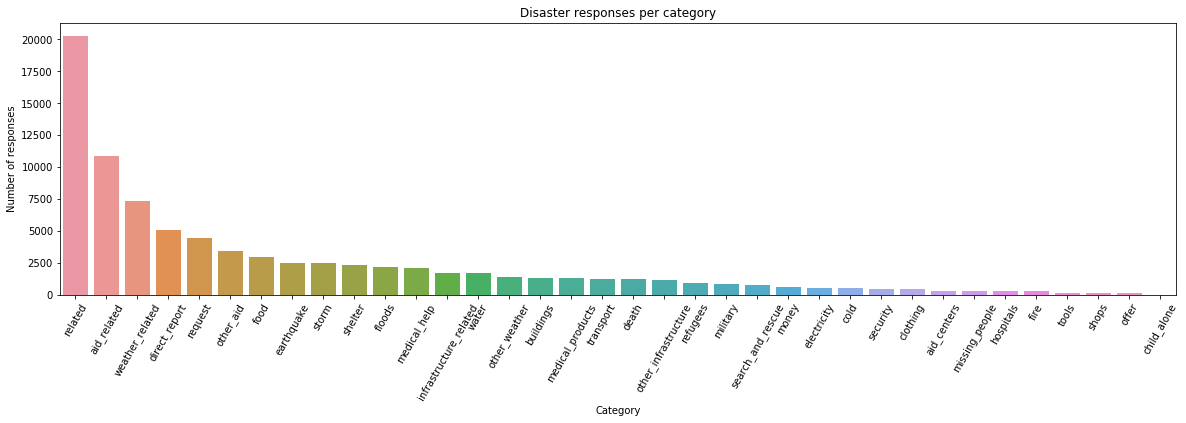

Model 1:
##################
Model training started
Model training completed
Prediction started
Prediction complete
                        accuracy  f1_score  precision    recall
earthquake              0.971468  0.911502   0.927297  0.897104
food                    0.951175  0.870415   0.889668  0.853541
water                   0.967806  0.854613   0.887576  0.827546
weather_related         0.887397  0.851919   0.880443  0.832650
clothing                0.992218  0.833515   0.897072  0.787883
floods                  0.958499  0.824674   0.936135  0.763536
storm                   0.944461  0.818790   0.868746  0.783177
request                 0.904181  0.806721   0.877305  0.766729
shelter                 0.944461  0.791834   0.903369  0.734809
aid_related             0.791730  0.781058   0.790809  0.776501
death                   0.968721  0.777896   0.874069  0.723622
direct_report           0.870156  0.748635   0.828787  0.712070
medical_products        0.956668  0.663106   0.906007

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  5.4min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 10.3min finished


Model training completed
Prediction started
Prediction complete
                        accuracy  f1_score  precision    recall
earthquake              0.970857  0.909468   0.925921  0.894532
food                    0.951327  0.871559   0.888315  0.856631
water                   0.967348  0.856887   0.876528  0.839500
weather_related         0.888770  0.855606   0.877128  0.839882
clothing                0.992371  0.841819   0.890158  0.804395
floods                  0.960330  0.836454   0.932763  0.779374
storm                   0.945529  0.827823   0.863192  0.800169
shelter                 0.947208  0.808486   0.901077  0.755624
request                 0.902045  0.808075   0.860743  0.774729
death                   0.969332  0.795349   0.859229  0.752304
aid_related             0.784559  0.775707   0.780256  0.772916
direct_report           0.869850  0.757880   0.815036  0.726731
medical_products        0.960787  0.722672   0.899608  0.659611
cold                    0.984284  0.7176

In [221]:
main()

#### Metrics summary:
Model 1- Highest F1:0.91 (earthquake) Lowest F1: 0.478(other aid)

Model 2- Highest F1:0.909 (earthquake) Lowest F1: 0.487 (infrastructure related)

Model 3- Highest F1: 0.911 (earthquake) Lowest F1: 0.478 (other aid)